<h1>SIFT KNN</h1>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tqdm import tqdm  
import pickle as pk

In [5]:
with open('./data/pickles/data.pkl', 'rb') as f:
    images, proba, types = pk.load(f)

In [6]:
_images = []
_proba = []
_types = []

for img, prob, typ in zip(images, proba, types):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    min_val, max_val, _, _ = cv2.minMaxLoc(img)
    cs_img = cv2.convertScaleAbs(img, alpha=255.0/(max_val - min_val), beta=-min_val * 255.0/(max_val - min_val))
    b_image = cv2.GaussianBlur(cs_img, (5, 5), 0)
    
    _images.extend([img,b_image])
    _proba.extend([prob] * 2)
    _types.extend([typ] * 2)

images = _images
proba = _proba
types = _types

In [7]:

labels = [f'{p}_{t}' for p, t in zip(proba, types)]

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42, stratify=labels)
Y_train_prob, Y_train_type = zip(*[label.split("_") for label in y_train])
Y_test_prob, Y_test_type = zip(*[label.split("_") for label in y_test])

Y_train_prob = [float(prob) for prob in Y_train_prob]
Y_test_prob = [float(prob) for prob in Y_test_prob]

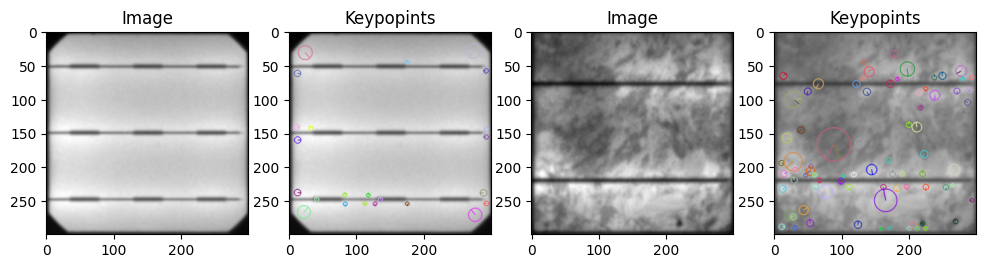

In [8]:
sift = cv2.SIFT_create()
img_1 = X_train[0].copy()
img_2 = X_train[20].copy()

keypoints, descriptors = sift.detectAndCompute(img_1, None)
img_1_kp = cv2.drawKeypoints(img_1, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
keypoints, descriptors = sift.detectAndCompute(img_2, None)
img_2_kp = cv2.drawKeypoints(img_2, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(img_1, cmap='gray'), plt.title('Image')
plt.subplot(142), plt.imshow(img_1_kp), plt.title('Keypopints')
plt.subplot(143), plt.imshow(img_2, cmap='gray'), plt.title('Image')
plt.subplot(144), plt.imshow(img_2_kp), plt.title('Keypopints')
plt.show()

In [9]:
def create_sift_feature_database(X_train, Y_train_prob, Y_train_type):
    sift = cv2.SIFT_create()
    desc = []
    sift_database = {
        'fully_functional': [],
        'possibly_defective': [],
        'likely_defective': [],
        'certainly_defective': []
    }

    for img, p, t in tqdm(zip(X_train, Y_train_prob, Y_train_type), total=len(X_train)):
        kp, des = sift.detectAndCompute(img, None)
        
        if des is not None:
            desc.extend(des)
        
        if p >= 0.99:
            img_class = 'certainly_defective'
        elif p >= 0.66:
            img_class = 'likely_defective'
        elif p >= 0.30:
            img_class = 'possibly_defective'
        else:
            img_class = 'fully_functional'

        sift_database[img_class].append(( des))

    return [desc,sift_database]

sift_features = create_sift_feature_database(X_train, Y_train_prob, Y_train_type)

list_of_desc = sift_features[0] 
train_features = sift_features[1]

100%|██████████| 3936/3936 [00:36<00:00, 107.16it/s]


In [10]:
X_test_mono = []
X_test_poly = []
Y_test_prob_mono = []
Y_test_prob_poly = []
Y_test_type_mono = []
Y_test_type_poly = []
for i in range(len(X_test)):
    if Y_test_type[i] == 'mono':
        X_test_mono.append(X_test[i])
        Y_test_prob_mono.append(Y_test_prob[i])
        Y_test_type_mono.append(Y_test_type[i])
    else:
        X_test_poly.append(X_test[i])
        Y_test_prob_poly.append(Y_test_prob[i])
        Y_test_type_poly.append(Y_test_type[i])       
        

In [11]:
def K_Means_Clustering(k, des):
    K_Means_Clustering = KMeans(n_clusters = k, n_init=10)
    K_Means_Clustering.fit(des)
    k_means_clusters = K_Means_Clustering.cluster_centers_ 
    return k_means_clusters

Y = (K_Means_Clustering(200, list_of_desc) )

In [12]:
test_features = create_sift_feature_database(X_test,Y_test_prob,Y_test_type)[1] 
test_features_mono = create_sift_feature_database(X_test_mono,Y_test_prob_mono,Y_test_type_mono)[1]
test_features_poly = create_sift_feature_database(X_test_poly,Y_test_prob_poly,Y_test_type_poly)[1]


100%|██████████| 775/775 [00:07<00:00, 110.34it/s]


In [15]:
class ImageClassifier:
    def __init__(self):
        pass

    @staticmethod
    def get_ith(img, c):
        itr = 0
        ith = 0
        i = 0

        while i < len(c):
            if i == 0:
                itr = np.linalg.norm(np.subtract(np.array(img), np.array(c[i])))
            else:
                dist = np.linalg.norm(np.subtract(np.array(img), np.array(c[i])))
                if dist < itr:
                    ith = i
                    itr = dist
            i += 1

        return ith

    def classifier(self, x, y):
        feat = {}

        for key, value in tqdm(x.items()):
            class_of_x = []
            for img in tqdm(value):
                hist = np.zeros(len(y))

                if img is not None and all(feature is not None for feature in img):
                    for each_feature in img:
                        ind = self.get_ith(each_feature, y)
                        hist[ind] += 1

                class_of_x.append(hist)
            feat[key] = class_of_x

        return feat

classifier = ImageClassifier()

In [16]:
train = classifier.classifier(train_features, Y) 

100%|██████████| 4/4 [04:27<00:00, 66.83s/it]


In [17]:
test = classifier.classifier(test_features, Y)
test_mono = classifier.classifier(test_features_mono, Y)
test_poly = classifier.classifier(test_features_poly, Y)

100%|██████████| 4/4 [01:15<00:00, 18.78s/it]


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import random

class CustomKNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.model = None

    def train(self, train_data):
        X_train = []
        y_train = []

        for key, features_list in train_data.items():
            X_train.extend(features_list)
            y_train.extend([key] * len(features_list))

        self.model = KNeighborsClassifier(n_neighbors=self.k)
        self.model.fit(X_train, y_train)

    def predict(self, test_data):
        true_labels = []
        predicted_labels = []

        for true_label, features_list in test_data.items():
            for features in features_list:
                true_labels.append(true_label)
                predicted_label = self.model.predict([features])[0]
                predicted_labels.append(predicted_label)

        return {
            "true_labels": true_labels,
            "predicted_labels": predicted_labels
        }


In [19]:
knn_classifier = CustomKNNClassifier(k=5)
knn_classifier.train(train)
results = knn_classifier.predict(test)
results_mono = knn_classifier.predict(test_mono)
results_poly = knn_classifier.predict(test_poly)

In [20]:
import pickle
with open('./data/pickles/knn_model.model', 'wb') as f:
    pickle.dump(knn_classifier, f)

In [17]:
correct_indices = [i for i, (true_label, pred_label) in enumerate(zip(results["true_labels"], results["predicted_labels"])) if true_label == pred_label]
incorrect_indices = [i for i, (true_label, pred_label) in enumerate(zip(results["true_labels"], results["predicted_labels"])) if true_label != pred_label]

# Visualize a correctly classified image
if correct_indices:
    index = random.choice(correct_indices)
    print("Correctly Classified Image:")
    print("True Label:", results["true_labels"][index])
    print("Predicted Label:", results["predicted_labels"][index])

# Visualize an incorrectly classified image
if incorrect_indices:
    index = random.choice(incorrect_indices)
    print("Incorrectly Classified Image:")
    print("True Label:", results["true_labels"][index])
    print("Predicted Label:", results["predicted_labels"][index])

Correctly Classified Image:
True Label: certainly_defective
Predicted Label: certainly_defective
Incorrectly Classified Image:
True Label: fully_functional
Predicted Label: certainly_defective


794


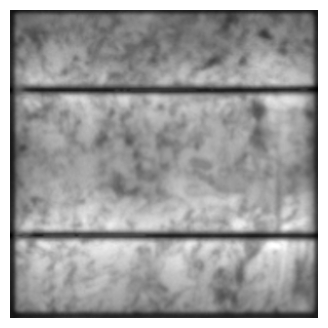

575


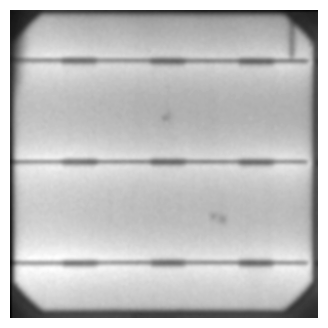

In [27]:

# Visualize a correctly classified image
if correct_indices:
    index = 794
    correct_image = X_test[index]
    print(index)

    plt.figure(figsize=(4, 4))
    plt.imshow(correct_image, cmap='gray')
    # plt.title(f'Correctly Classified\nTrue Label: {results["true_labels"][index]}, Predicted Label: {results["predicted_labels"][index]}')
    plt.axis('off')
    plt.show()


# Visualize an incorrectly classified image
if incorrect_indices:
    index = 575
    incorrect_image = X_test[index]
    print(index)
    plt.figure(figsize=(4, 4))
    plt.imshow(incorrect_image, cmap='gray')
    # plt.title(f'Incorrectly Classified\nTrue Label: {results["true_labels"][index]}, Predicted Label: {results["predicted_labels"][index]}')
    plt.axis('off')
    plt.show()


In [19]:
print("Accuracy:", accuracy_score(results["true_labels"], results["predicted_labels"]))
print("Accuracy Mono:", accuracy_score(results_mono["true_labels"], results_mono["predicted_labels"]))
print("Accuracy Poly:", accuracy_score(results_poly["true_labels"], results_poly["predicted_labels"]))

print("F1 Score:",f1_score(results["true_labels"], results["predicted_labels"], average='weighted'))
print("F1 Score Mono:",f1_score(results_mono["true_labels"], results_mono["predicted_labels"], average='weighted'))
print("F1 Score Poly:",f1_score(results_poly["true_labels"], results_poly["predicted_labels"], average='weighted'))


Accuracy: 0.7149390243902439
Accuracy Mono: 0.707635009310987
Accuracy Poly: 0.72
F1 Score: 0.6893425949744325
F1 Score Mono: 0.6712646137346184
F1 Score Poly: 0.7027678255473864
